## SIM Training by Stein's Method

In [1]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, roc_auc_score

from pysim import SimClassifier

## pySIM - A python package for Sparse SIM 

**To install**:
    
```sheel
    pip install git+https://github.com/Zebinyang/pysim.git
```

Note pysim will call the R package fps (https://github.com/vqv/fps) using rpy2 interface. 

```python
from pysim import SimClassifier
clf = SimClassifier(method="first_order", reg_lambda=0.1, spline="smoothing_spline", reg_gamma=10, knot_num=20, knot_dist="uniform", degree=2, random_state=0)
## clf.fit(x, y)
```

**Usage**

**Hyperparameters**

- method: the base method for estimating the projection coefficients in sparse SIM. default="first_order"

        "first_order": First-order Stein's Identity via sparse PCA solver

        "second_order": Second-order Stein's Identity via sparse PCA solver

        "first_order_thres": First-order Stein's Identity via hard thresholding (A simplified verison)        
    
- reg_lambda: The regularization strength of sparsity of beta. default=0.1, from 0 to 1 

- spline: The type of spline for fitting the curve. default="smoothing_spline"
        
        "smoothing_spline": Smoothing spline

        "p_spline": P-spline

        "mono_p_spline": P-spline with monotonic constraint
        
        "a_spline": Adaptive B-spline

- reg_gamma: The regularization strength of the spline algorithm. default=0.1.

        For spline="smoothing_spline", it ranges from 0 to 1 
        
        For spline="p_spline","mono_p_spline" or "a_spline", it ranges from 0 to $+\infty$.

- degree: The order of the spline basis, , not used in "smoothing_spline". default=2

- knot_num: The number of knots, not used in "smoothing_spline". default=20

- knot_dist: The method of specifying the knots, only used in "a_spline". default="uniform"

        "uniform": uniformly over the domain
        
        "quantile": uniform quantiles of the given input data (not available when spline="p_spline" or "mono_p_spline")

- random_state: the random seed. default=0

# Case 1: Logit Function

In [20]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = 1 / (1 + np.exp(-(np.dot(x, beta)))) + 0.1 * np.random.randn(n_samples)
y = y - np.mean(y)
y[y <= 0] = 0
y[y > 0] = 1

The best hyperparameter combination can be selected via cross-validation

In [21]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.1, 0.2, 0.3, 0.4, 0.5], 
              "reg_gamma": np.logspace(-5, -1, 5)}
grid = GridSearchCV(SimClassifier(spline="smoothing_spline", knot_num=20, random_state=0), iid=False,
                    cv=KFold(3, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  99 out of 150 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


CPU times: user 3.73 s, sys: 7.05 s, total: 10.8 s
Wall time: 1.92 s


In [22]:
grid.best_params_

{'method': 'first_order', 'reg_gamma': 1e-05, 'reg_lambda': 0.1}

**NB**: The first-order Setin's method is selected, as $\mathbb{E}[f^{\prime\prime}(u)]=0$. Therefore, the second order method cannot provide any information about the projection coefficients. 

In this case, the first-order Setin's method is selected. 

In [23]:
clf = grid.best_estimator_
clf

SimClassifier(degree=2, knot_dist='uniform', knot_num=20, method='first_order',
              random_state=0, reg_gamma=1e-05, reg_lambda=0.1,
              spline='smoothing_spline')

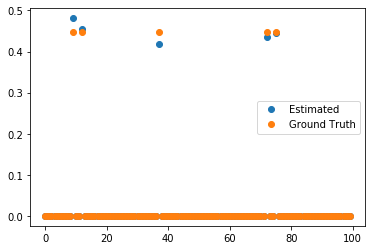

In [24]:
plt.plot(np.abs(clf.beta_), "o")
plt.plot(np.abs(beta), "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

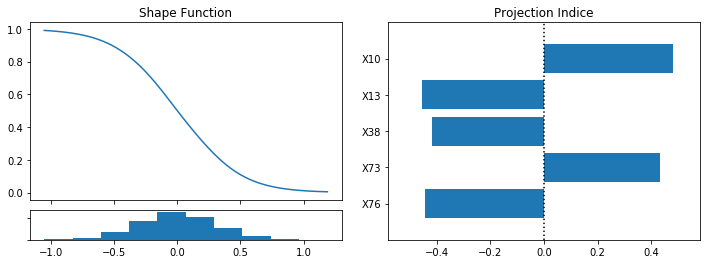

In [25]:
grid.best_estimator_.visualize()

In [8]:
roc_auc_score(y, grid.predict_proba(x))

0.776549688149555

## Case 2: Quadratic Ridge Function

In [31]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = 5 * np.dot(x, beta) ** 2 + 0.1 * np.random.randn(n_samples)
ymu = np.mean(y)
y[y > ymu] = 1
y[y <= ymu] = 0

In [41]:
y.mean()

0.3229

In [32]:
%%time 

param_grid = {"method": ["second_order"],
              "reg_lambda": [0.1, 0.2, 0.3, 0.4, 0.5], 
              "reg_gamma": np.logspace(-5, -1, 5)}
grid = GridSearchCV(SimClassifier(spline="smoothing_spline", knot_num=20, random_state=0), iid=False,
                    cv=KFold(3, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  75 | elapsed:    0.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  62 out of  75 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.8s finished
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


CPU times: user 3.36 s, sys: 6.91 s, total: 10.3 s
Wall time: 1.1 s


In [33]:
grid.best_params_

{'method': 'second_order', 'reg_gamma': 1e-05, 'reg_lambda': 0.1}

**NB**: The second-order Setin's method is selected, as $\mathbb{E}[f^{\prime}(u)]=0$. Therefore, the first order method cannot provide any information about the projection coefficients. 

In [34]:
clf = grid.best_estimator_
clf

SimClassifier(degree=2, knot_dist='uniform', knot_num=20, method='second_order',
              random_state=0, reg_gamma=1e-05, reg_lambda=0.1,
              spline='smoothing_spline')

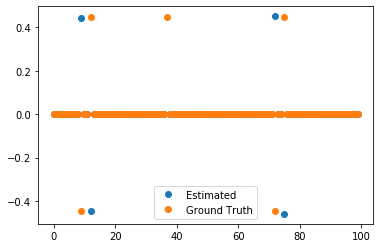

In [35]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

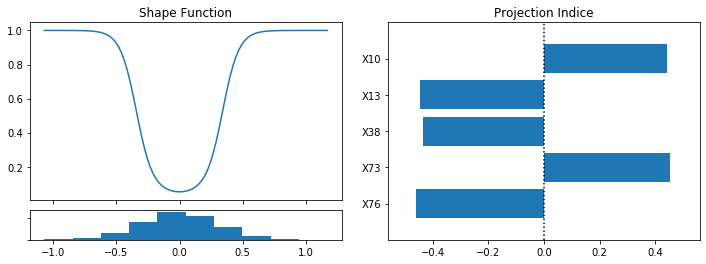

In [36]:
grid.best_estimator_.visualize()

In [44]:
clf.decision_function(x).min()

0.05284495238721615

## Case 3: Improve a rough estimator via inner update

In [15]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.gamma(1, 0.3, size=(n_samples, n_features))
y = 5 * np.dot(x, beta) ** 2 + 0.1 * np.random.randn(n_samples)
ymu = np.mean(y)
y[y > ymu] = 1
y[y <= ymu] = 0

In [16]:
%%time 

clf = SimClassifier(degree=2, knot_num=20, reg_lambda=0.1, reg_gamma=0.4, spline="a_spline", random_state=0)
clf.fit(x, y)

CPU times: user 5.29 s, sys: 15.1 s, total: 20.4 s
Wall time: 491 ms


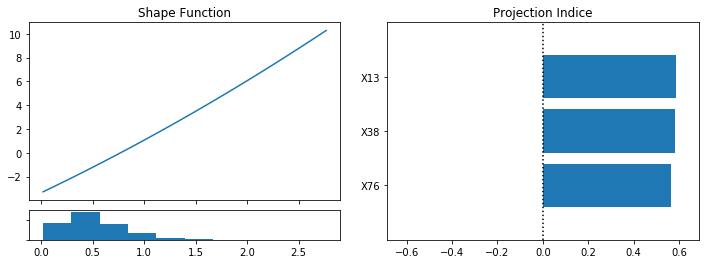

In [17]:
clf.visualize()

**Remark**：The data does not follow a normal distribution, so the performance is relatively poor.

In [18]:
clf.fit_inner_update(x, y, verbose=True, n_inner_iter_no_change=5)

Inner iter: 1 epoch: 1 with validation loss: 0.42561
Inner iter: 1 epoch: 2 with validation loss: 0.42303
Inner iter: 1 epoch: 3 with validation loss: 0.42298
Inner iter: 1 epoch: 4 with validation loss: 0.42287
Inner iter: 1 epoch: 5 with validation loss: 0.42304
Inner iter: 1 epoch: 6 with validation loss: 0.42261
Inner iter: 1 epoch: 7 with validation loss: 0.42248
Inner iter: 1 epoch: 8 with validation loss: 0.42178
Inner iter: 1 epoch: 9 with validation loss: 0.42114
Inner iter: 1 epoch: 10 with validation loss: 0.42207
Inner iter: 1 epoch: 11 with validation loss: 0.42101
Inner iter: 1 epoch: 12 with validation loss: 0.42157
Inner iter: 1 epoch: 13 with validation loss: 0.42206
Inner iter: 1 epoch: 14 with validation loss: 0.41996
Inner iter: 1 epoch: 15 with validation loss: 0.4215
Inner iter: 1 epoch: 16 with validation loss: 0.42005
Inner iter: 1 epoch: 17 with validation loss: 0.42023
Inner iter: 1 epoch: 18 with validation loss: 0.41942
Inner iter: 1 epoch: 19 with validatio

**Remark**: fit_inner_update is not available for spline="p_spline" or "mono_p_spline"

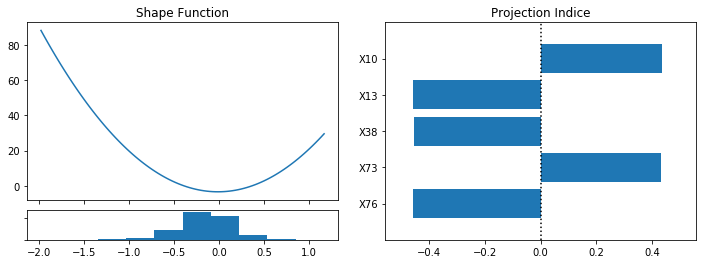

In [19]:
clf.visualize()